In [1]:
import math
import numpy as np
import torch
import torch.autograd as autograd
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
import os 

import laplace




In [2]:
%config InlineBackend.figure_format = 'retina'
sns.set(style="darkgrid")
matplotlib.rcParams['figure.dpi']= 200
sns.set(style="white")

In [3]:
class RBF(torch.nn.Module):
    def __init__(self, M=None, h=None):
        super(RBF, self).__init__()

        self.h = h
        
    def median(self,tensor):
        tensor = tensor.flatten().sort()[0]
        length = tensor.shape[0]

        if length % 2 == 0:
            szh = length // 2
            kth = [szh - 1, szh]
        else:
            kth = [(length - 1) // 2]
        return tensor[kth].mean()
    


    def forward(self, X, Y, M=None):

        #average curvature tensor
        if M == None:
            M = torch.eye(X.shape[0])


        XX = X.matmul(X.t())
        XY = X.matmul(Y.t())
        YY = Y.matmul(Y.t())

        dnorm2 = -2 * XY + XX.diag().unsqueeze(1) + YY.diag().unsqueeze(0)
        
        
        # Apply the median heuristic (PyTorch does not give true median)
        if self.h is None:
            h = self.median(dnorm2.detach()) / (2*torch.tensor(math.log(X.size(0))))
        else:
            h = self.h**2

        gamma = 1.0 / (2*h)
        K_XY = (-gamma * dnorm2).exp()

        return K_XY

In [4]:
class SVGD:
    def __init__(self, P, K, optimizer):
        self.P = P
        self.K = K
        self.optim = optimizer

    def phi(self, X):
        X = X.detach().requires_grad_(True)


        log_prob = self.P.log_prob(X)
        score_func = autograd.grad(log_prob.sum(), X)[0]


        K_XX = self.K(X, X.detach())
        grad_K = -autograd.grad(K_XX.sum(), X)[0]


        phi = (K_XX.detach().matmul(score_func) + grad_K) / X.size(0)        

        return phi

    def step(self, X):
        self.optim.zero_grad()
        X.grad = -self.phi(X)
        self.optim.step()

In [5]:
import torch
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal

class GaussianModel(nn.Module):
    def __init__(self, input_size):
        super(GaussianModel, self).__init__()
        self.mu = nn.Parameter(torch.Tensor([-0.68,0.80]))
        self.covariance_matrix = 5 * torch.Tensor([[0.22,0.16],[0.16,0.67]]) # Using covariance matrix

        self.distribution = torch.distributions.MultivariateNormal(self.mu.to(device),
        covariance_matrix=self.covariance_matrix.to(device))

    def sample(self, x):
        return self.distribution.sample(x)

    def forward(self, x):
        #add batch dimension
        return self.distribution.sample().unsqueeze(0) 
    
    def log_prob(self, X):
        return self.distribution.log_prob(X)
    


In [46]:
import torch
import torch.nn as nn

class ParticleModel(nn.Module):
    def __init__(self, model, initial_params=None):
        super(ParticleModel, self).__init__()
        
        # Initialize the parameters
        if initial_params is None:
            initial_params = torch.tensor([0.0, 0.0])
        self.params = nn.Parameter(initial_params)  # Define custom parameters

        self.model = model

    def forward(self, x):

        temp = [p for p in self.parameters()]
        params_tensor = torch.empty(len(temp))

        for i in range(len(temp)):
            params_tensor[i] = temp[i]
        
        #print('abcsdf')
        #print(torch.tensor(self.params).shape)
        #print(torch.tensor(self.params))


        #output = params_tensor.unsqueeze(0)  # Return the custom parameters
        output = x.unsqueeze(0)
        print(' particel model output shape')
        print(output.shape)

        return output

    '''def loss(self, x):
        # Compute negative log probability
        
        #print('paramters in partile model')
        #print(self.params.shape)
        #print(self.params)
        
        negative_log_prob = -self.model.log_prob(x)
        return negative_log_prob'''


In [7]:
def plot_density_particles(samples,particles,name):
    g = sns.JointGrid(x=samples[:,0],y=samples[:,1])
    
    #Particles 
    sns.scatterplot(x=particles.detach().numpy()[:,0],y=particles.detach().numpy()[:,1], color ='orange', ax = g.ax_joint, alpha = 1.0,s = 50, zorder = 1, edgecolor='black', label = name)
    plt.legend(fontsize=20)

    #KDE of target distribution
    sns.kdeplot(x=samples[:,0],y=samples[:,1] ,cmap=plt.cm.Blues, fill=True, levels=15, ax=g.ax_joint, zorder = 0)
    
    g.ax_joint.legend()

    plt.axis('off')
    
    plt.savefig(name+'.pdf', format='pdf',dpi = 200)
    return g 




In [39]:
gauss = torch.distributions.MultivariateNormal(torch.Tensor([-0.68,0.80]).to(device),
        covariance_matrix=5 * torch.Tensor([[0.22,0.16],[0.16,0.67]]).to(device))

# Example usage
input_size = 2 #paramter useless for now
gaussianmodel = GaussianModel(input_size)



n = 10
#X_init = (3 * torch.randn(n, *gauss.event_shape)).to(device)
p_0 = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([-1,5],dtype=torch.float),0.5*torch.eye(2))

particle_model = ParticleModel(gaussianmodel, p_0.sample())

X_init = p_0.sample(torch.Size([n]))

In [47]:
samples = gaussianmodel.sample(torch.Size([4000])).detach().numpy()


In [25]:
K = RBF(0.5)
lr = 1e-1

In [44]:
from laplace import FullLaplace
from laplace import Laplace
from laplace import ParametricLaplace
from torch.utils.data import DataLoader, TensorDataset


class SVN:
    def __init__(self, P, particle_model, K, optimizer, DoF, nIterations, nParticles):
        self.P = P 
        self.K = K
        self.optim = optimizer

        self.particle_model = particle_model

        #new stuff
        self.DoF = DoF
        self.nIterations = nIterations
        self.nParticles = nParticles
        self.maxmaxshiftold = np.inf
        self.maxshift = np.empty(self.nParticles)
        self.Q = torch.empty(self.DoF, self. nParticles)

    def phi(self, X):
        
        X = X.detach().requires_grad_(True)
        F = self.P.forward(X).requires_grad_(True)

        log_prob = self.P.log_prob(X)
        score_func = autograd.grad(log_prob.sum(), X)[0]
        J = score_func

        gmlpt  =  score_func 
        

        Hessians = []
        for i in range(self.nParticles):
            
            particle = X[i]

            #print('bevore 12344 particle mdoel paramters')
            #print([p for p in self.particle_model.parameters()])

            params_list = [p for p in self.particle_model.parameters()]
            for k in range(len(params_list)):
                params_list[k].data = particle[k]

            print('particle')
            print(particle)

            print('particle mdoel paramters')
            print([p for p in self.particle_model.parameters()])

            #print('model loss')
            #print(self.particle_model.loss(particle).shape)
            #print(self.particle_model.loss(particle))


            #labels = self.particle_model.loss(particle)
            labels = self.P.log_prob(particle)
            labels = labels.unsqueeze(0).requires_grad_(True)
            particle = particle.unsqueeze(0).requires_grad_(True)
            #labels = self.P.log_prob(particle).requires_grad_(True) #.unsqueeze(0) 
            #labels = F[i].unsqueeze(0)

           
            print(particle)
            print(labels)

            # Create a DataLoader for the single particle
            particle_loader = DataLoader(TensorDataset(particle, labels), batch_size=1)
            laplace_particle_model = FullLaplace(self.particle_model, likelihood='regression')
            laplace_particle_model.fit(particle_loader)
            
    
            Hessian = laplace_particle_model.posterior_precision
            Hessians.append(Hessian)
            
        Hmlpt = torch.empty(self.nParticles, X[0].shape[0], X[0].shape[0])

        for i in range(len(Hessians)):
            Hmlpt[i] = torch.tensor(Hessians[i])

        print("Hessian:")
        print(Hmlpt[0].shape)
        print(Hmlpt.shape)


        #mean curvature tensor
        M = Hmlpt.posterior_precision // self.nParticles        


        #compute gradient of Kernel matrix: 
        K_XX = self.K(X, X.detach(), M)
        grad_K = -autograd.grad(K_XX.sum(), X)[0]

        grad_J = (K_XX.detach().matmul(score_func) + grad_K) / self.nParticles   

        
        HJ  = np.mean(Hmlpt.posterior_precision * K_XX ** 2, 2) + np.matmul(grad_K, grad_K.T) / self.nParticles


        self.Q[:0] = np.linalg.solve(HJ, mgJ)

        phi = self.Q

        
        for i_ in range(X.shape[0]):
            sign_diff = X[:,i_,np.newaxis] - X.shape[0]


            Msd = M @ sign_diff

            #Msd   = np.matmul(M, sign_diff)
            kern  = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
            
            gkern = Msd * kern
            
            mgJ = np.mean(- gmlpt * kern + gkern , 1)
            HJ  = np.mean(Hmlpt.posterior_precision * kern ** 2, 2) + np.matmul(gkern, gkern.T) / self.nParticles
            
            self.Q[:,i_] = np.linalg.solve(HJ, mgJ)
            self.maxshift[i_] = np.linalg.norm(self.Q[:,i_], np.inf)
        
        phi = self.Q
        maxmaxshift = np.max(self.maxshift)
        
        if np.isnan(maxmaxshift) or (maxmaxshift > 1e20):
            print('Reset particles...')
            self.resetParticles()
            self.stepsize = 1

        elif maxmaxshift < self.maxmaxshiftold:
            self.stepsize *= 1.01
        else:
            self.stepsize *= 0.9
            
        self.maxmaxshiftold = maxmaxshift

        return phi


    def step(self, X):
        self.optim.zero_grad()
        X.grad = -self.phi(X)
        self.optim.step()


In [48]:
X_SVGD = X_init.clone() 
X_SVN = X_init.clone()

svgd = SVGD(gaussianmodel,K, optim.Adam([X_SVGD], lr=lr))


att_l = []
rep_l = []
t_steps = 1000

svn = SVN(gaussianmodel,  particle_model,  K, optim.Adam([X_SVGD], lr=lr), DoF=input_size, nIterations = t_steps, nParticles=n)

for i in tqdm(range(t_steps),position=0, leave=True):       
    svgd.step(X_SVGD)
    svn.step(X_SVN)

  0%|          | 0/1000 [00:00<?, ?it/s]

particle
tensor([-0.8165,  5.5468], grad_fn=<SelectBackward0>)
particle mdoel paramters
[Parameter containing:
tensor(-0.8165, requires_grad=True), Parameter containing:
tensor(5.5468, requires_grad=True)]
tensor([[-0.8165,  5.5468]], grad_fn=<UnsqueezeBackward0>)
tensor([-6.6449], grad_fn=<UnsqueezeBackward0>)
 particel model output shape
torch.Size([1, 2])
 particel model output shape
torch.Size([1, 2])


RuntimeError: Function torch::autograd::CopySlices returned an invalid gradient at index 1 - got [] but expected shape compatible with [2]

In [31]:
[p for p in particle_model.parameters()]

[Parameter containing:
 tensor(-0.4752, requires_grad=True),
 Parameter containing:
 tensor(5.2050, requires_grad=True)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


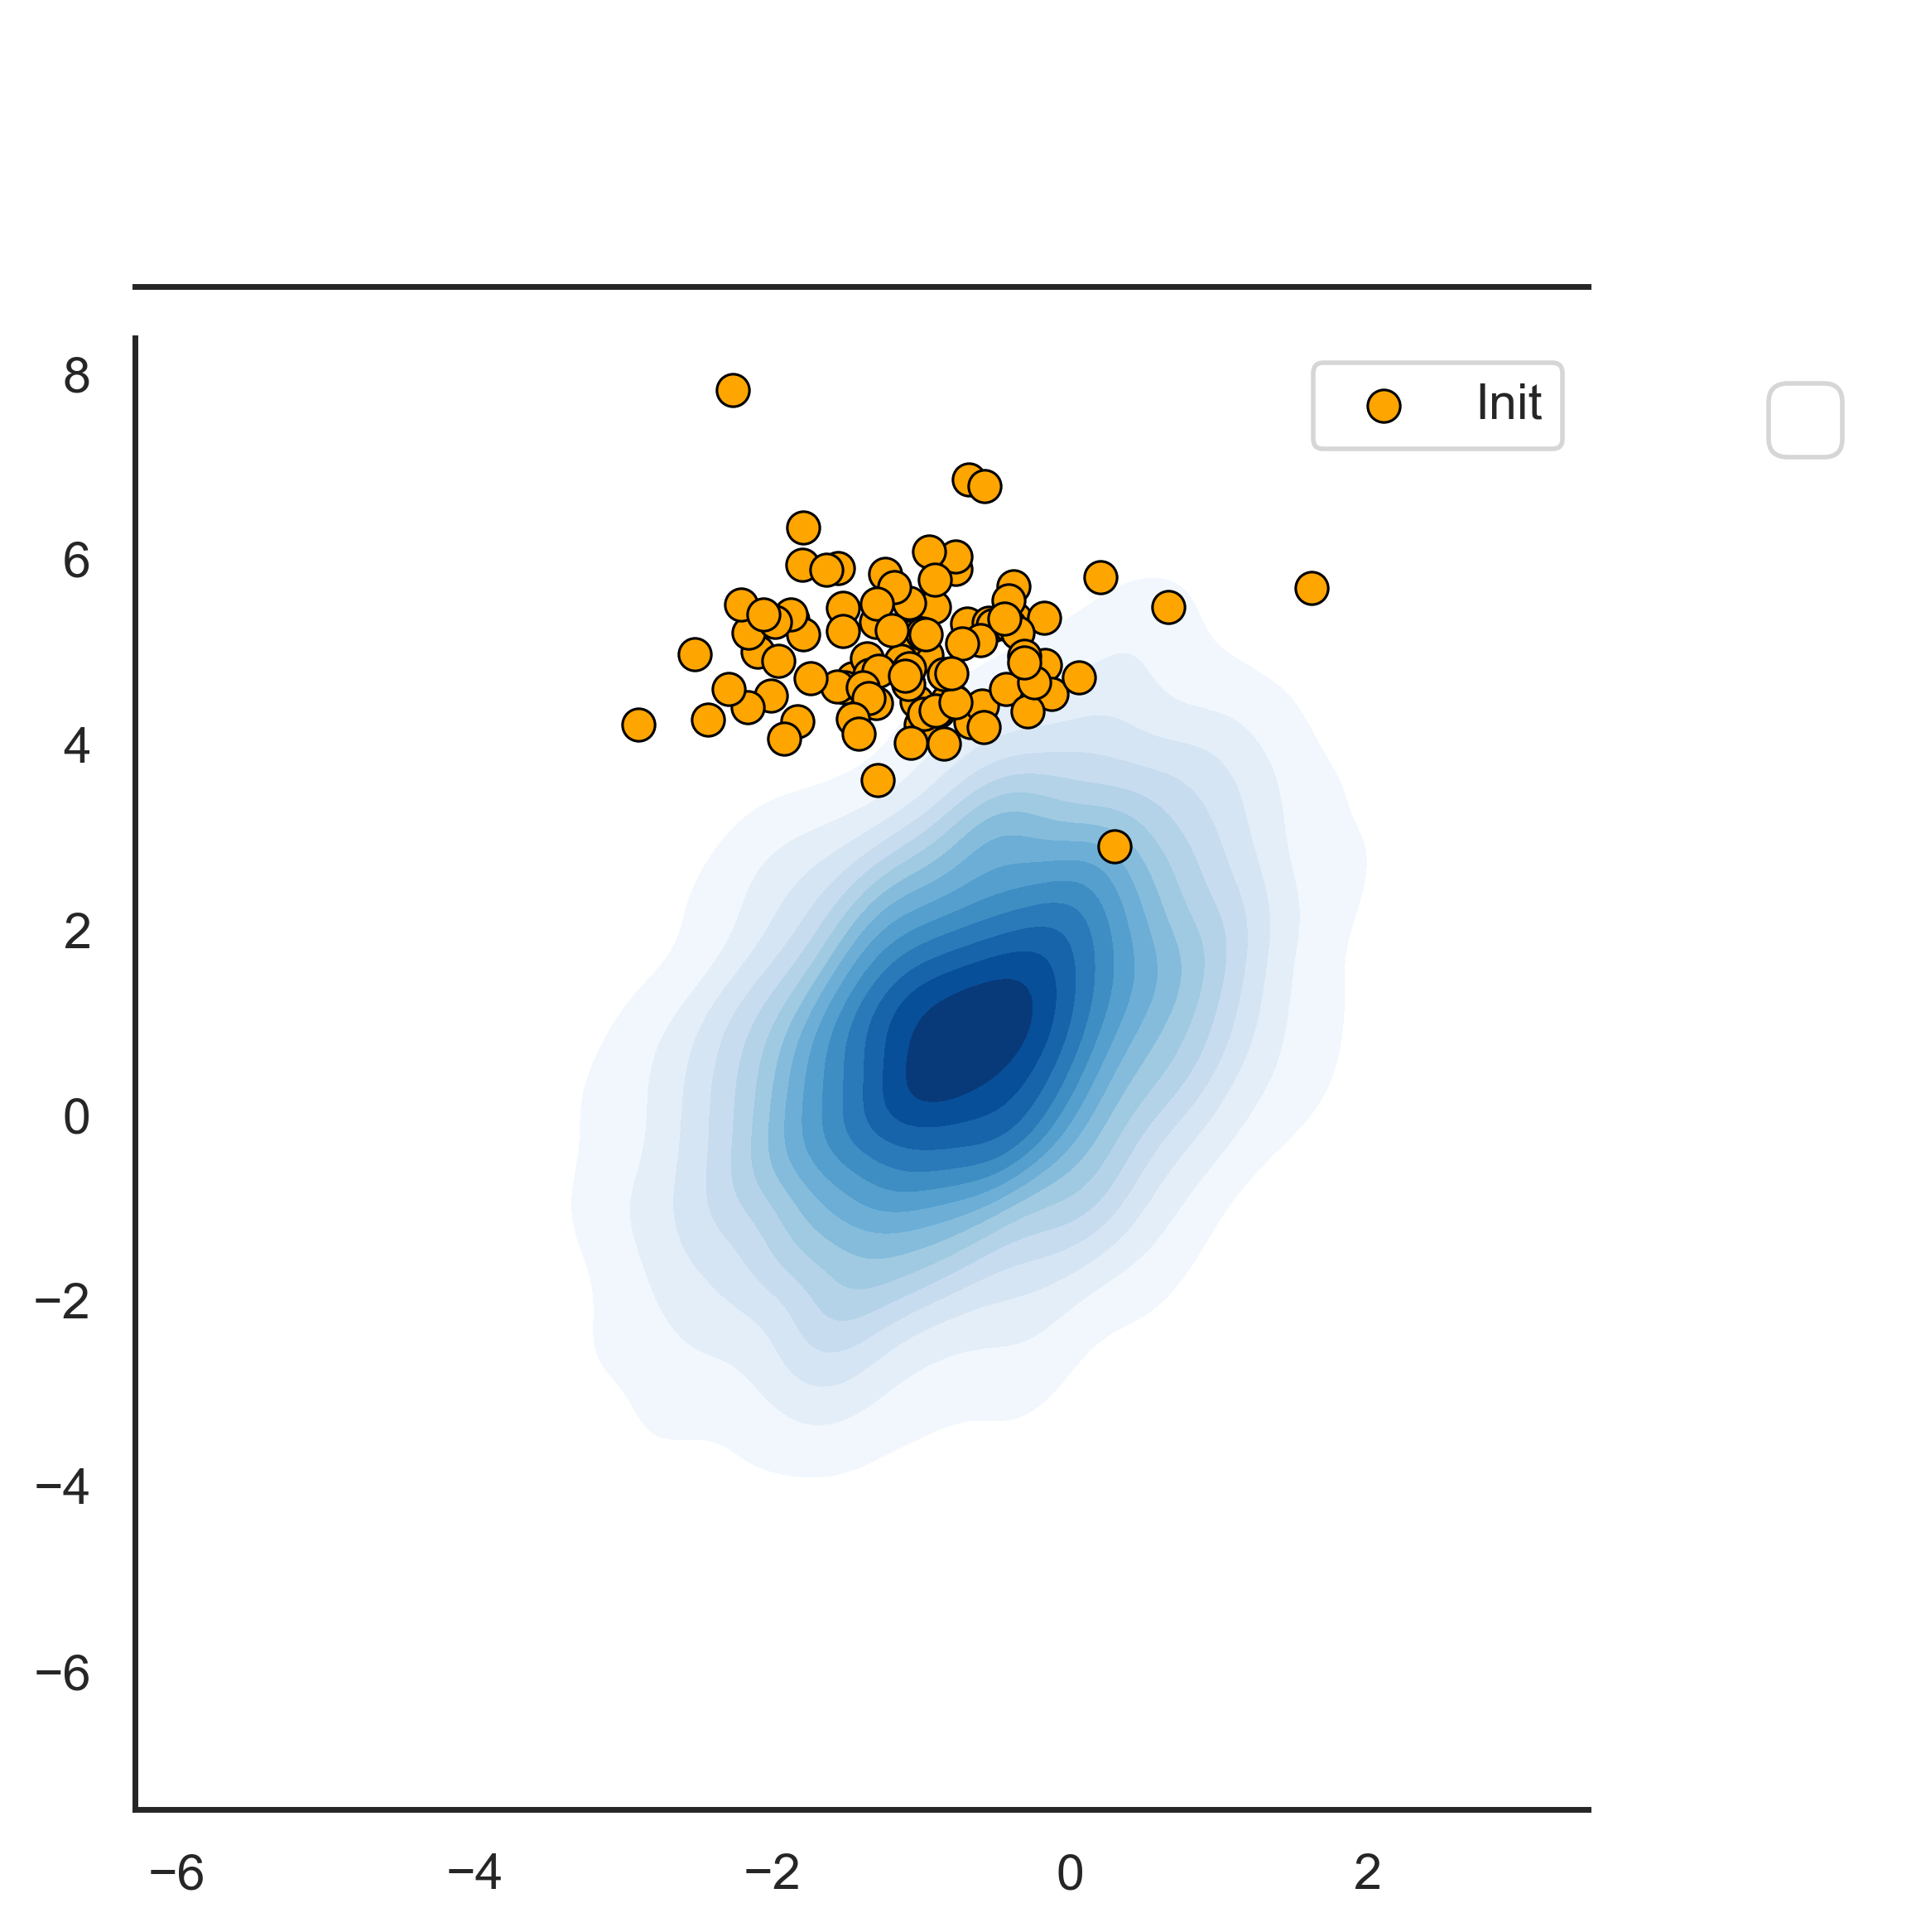

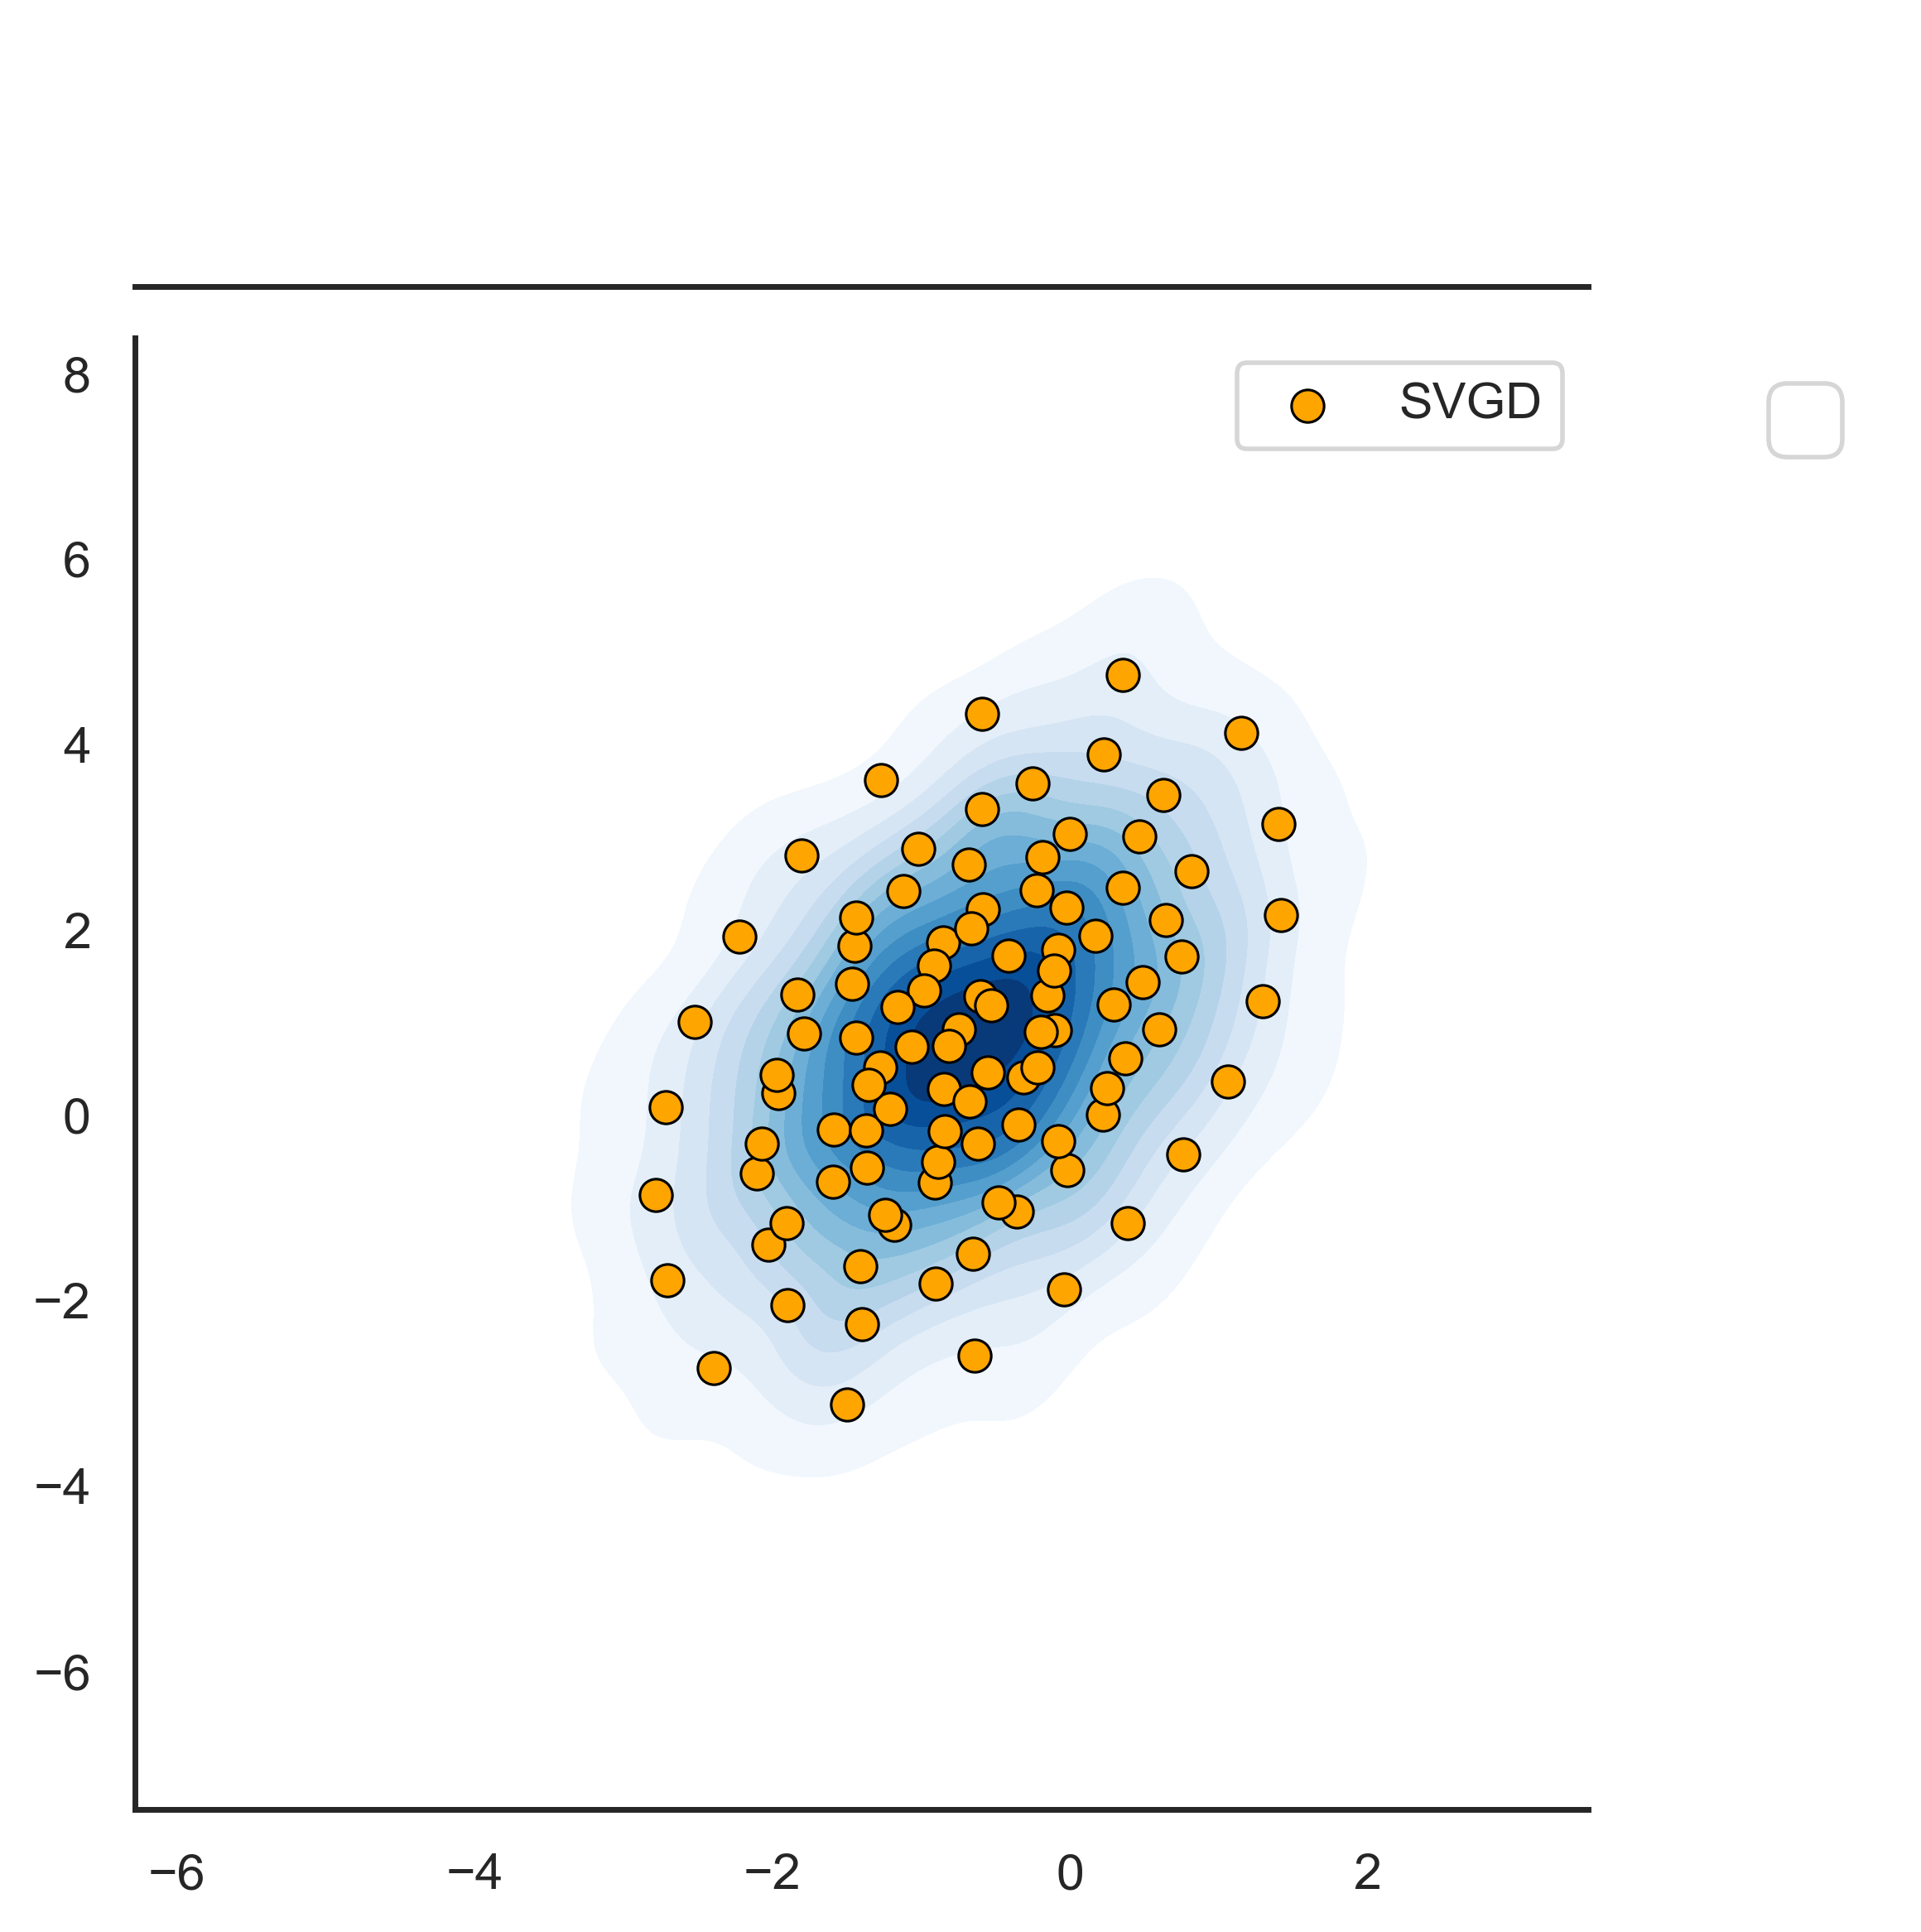

In [ ]:
plot_density_particles(samples,X_init,'Init')
plot_density_particles(samples,X_SVGD,'SVGD')